## Calibration matrix computation

Here we compute the calibration matrix given the calibration images. 

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

In [2]:
class CameraParams:
    def __init__(self, ret, mtx, dist, rvecs, tvecs):
        self.ret = ret
        self.mtx = mtx
        self.dist = dist
        self.rvces = rvecs
        self.tvecs = tvecs

In [7]:
def cameraCalibration(globPath):
    # prepare object points, like (0,0,0) (1,0,0), (2,0,0) ...., (6,5,0)
    objp = np.zeros((6*9, 3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
    
    # Arrays to store object points and immage points from all the images.
    objpoints = []    # 3d points in real world space
    imgpoints = []  # 2d points in image plane
    
    # Make a list of calibration images
    images = glob.glob(globPath)
    
    imshape = None
    
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if imshape is None:
            imshape = gray.shape
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            # Draw and display the corners
            #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #plt.imshow(img)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imshape[::-1], None, None)
    return CameraParams(ret, mtx, dist, rvecs, tvecs)  

In [8]:
globpath= './camera_cal/calibration*.jpg'
cameraParams = cameraCalibration(globpath)

### Undistort a test image

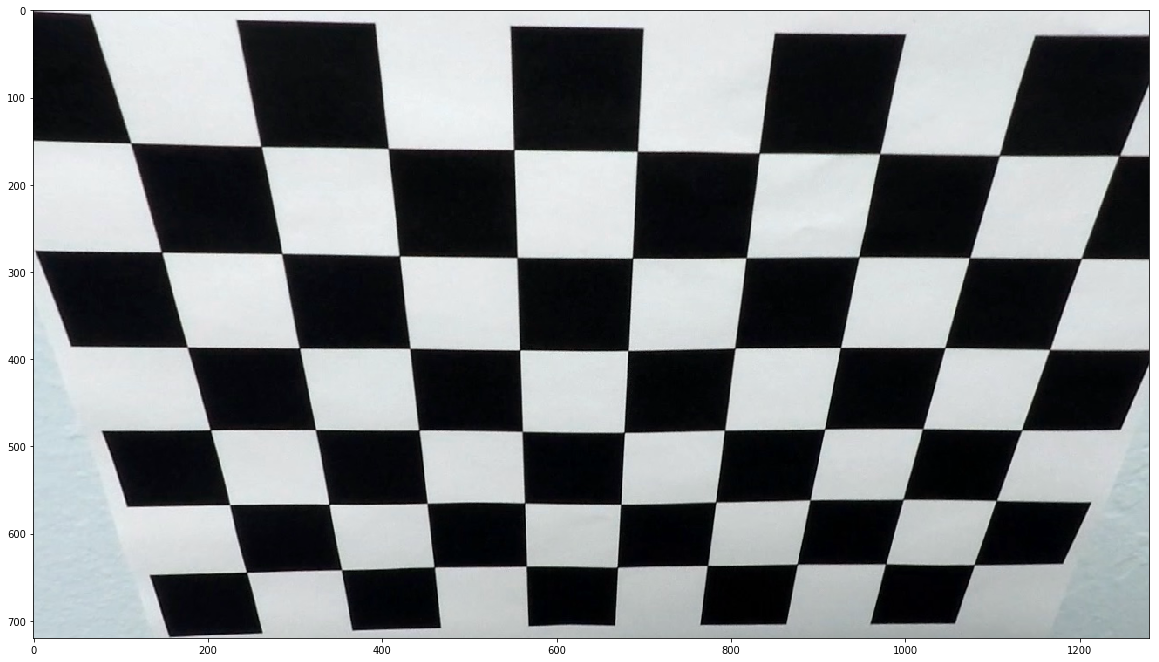

In [10]:
img = cv2.imread('./camera_cal/calibration2.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
dst = cv2.undistort(img, cameraParams.mtx, cameraParams.dist, None, cameraParams.mtx)
fig = plt.figure(figsize=(20,20))
plt.imshow(dst)

## Various transforms

### Color space transform

We first define RGB->HLS color space transformation.

NOTE: In all the following functions, I have used cv2.COLOR_BGR2* since the images are read using OpenCV

In [11]:
# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s = hls[:,:,2]
    binary_output = np.zeros_like(s)
    binary_output[(s <= thresh[1]) & (s > thresh[0])] = 1
    return binary_output
 

### Gradient thresholding

I now create functions to apply various threshols on the magnitude and the direction of the gradients of an image. I have chosen the Sobel operator to generate the gradients. 

#### Sobel thresholding

In [12]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        print('Wrong orientation specified')
        return np.zeros_like(gray)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel / np.max(abs_sobel))
    mask = np.zeros_like(scaled_sobel)
    mask[(scaled_sobel <= thresh[1]) & (scaled_sobel >= thresh[0])] = 1
    binary_output = mask # np.copy(img) # Remove this line
    return binary_output
    
## Run the function
## grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)


#### Second, magnitude thresholding

In [13]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel <= mag_thresh[1]) & (scaled_sobel >= mag_thresh[0])] = 1
    return binary_output
    
## Run the function
## mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))


#### Third, direction thresholding

In [14]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    direction = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(direction)
    binary_output[(direction <= thresh[1]) & (direction >= thresh[0])] = 1
    return binary_output
    
## Run the function
## dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))

### Main threshold function

In [15]:
def threshold(img):
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 150))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 150))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
    #dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))
    dir_binary = dir_threshold(img, sobel_kernel=ksize*5, thresh=(0.7, 1.3))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    hls_binary = hls_select(img, thresh=(90, 255))
    combined_binary = np.zeros_like(hls_binary)
    combined_binary[(combined == 1) | (hls_binary == 1)] = 1
    
    return combined_binary

### Compute the perspective transform

In [16]:
def getPerspectiveMatrix():
    src = np.array([[220,710],[1089,710], [692,455], [590,455]], dtype=np.float32)
    dst = np.array([[300,710],[1000,710],[1000,10],[300,10]], dtype=np.float32)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M,Minv

### Lane line detection

#### Some data structures

In [17]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [18]:
class LineFitParams():
    def __init__(self):
        self.left_lane_inds = None
        self.left_lane_inds = None
        self.left_fit = None
        self.right_fit = None
        self.nonzerox = None
        self.nonzeroy = None
        self.out_img = None

In [19]:
def sliding_window(img, prev_left, prev_right):
    histogram = np.sum(img[img.shape[0]//2:.:], axis=0)
    
    # Horizontal midpoint
    midpoint = np.int(histogram.shape[0]/2)
    
    # Get the left and right peaks in the histogram
    # These are the left and right bases for the lane lines
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:])
    
    nwindows = 9
    windows_height = np.int(img.shape[0]/nwindows)
    # x and y positions of all the nonnzero pixels
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # current posiitions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the window +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and left and right)
        win_y_low = img.shape[0] - (window+1)*window_heigt
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify nonzero pixel in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xleft_low) & (nonzerox < win_x_left_high)).nonzero()
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high)  &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()
        
        # Append the indices to the list
        left_lane_indices.append(good_left_inds)
        right_lane_indices.append(good_right_inds)
        
        # If there are more than minpix pixels in the good indices, recenter next window to the mean of the pixels
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzeero[good_right_inds]))
        
    # Concatenate the arrays of the indices ???
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right pixel positions
    #??? These are the allx and ally ???
    leftx = nonzero[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    # Line.current_fit!!
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = no.polyfit(righty, rightx, 2)
    
    left = prev_left
    left.detected = True
    left.recent_xfitted.push(left_fit)
    if not left.current_fit.empty():
        left.diffs = left.current_fit - left_fit
    left.current_fit = left_fit
    left.allx = leftx
    left.ally = lefty
    
    right = prev_right
    right.detected = True
    right.recent_xfitted.push(right_fit)
    if not right.current_fit.empty():
        right.diffs = right.current_fit - right_fit
    right.current_fit = right_fit
    right.allx = rightx
    right.ally = righty
    
    return (left,right)

In [20]:
def visualize(img, params):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = params.left_fit[0]*ploty**2 + params.left_fit[1]*ploty + params.left_fit[2]
    right_fitx = params.right_fit[0]*ploty**2 + params.right_fit[1]*ploty + params.right_fit[2]
    
    out_img = params.out_img
    out_img[params.nonzeroy[params.left_lane_inds], params.nonzerox[params.left_lane_inds]] = [255, 0, 0]
    out_img[params.nonzeroy[params.right_lane_inds], params.nonzerox[params.right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    

In [21]:
def margin_search(img, params):
    # Assume you now have a new warped binary image
    # from the next frame of video
    # It's now much easier to find line pixels
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_fit = params.left_fit
    right_fit = params.right_fit
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) &
        (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) &
        (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extracct left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    params = LineFitParams()
    params.left_fit = left_fit
    params.right_fit = right_fit
    params.nonzerox = nonzerox
    params.nonzeroy = nonzeroy
    params.left_lane_inds = left_lane_inds
    params.right_lane_inds = right_lane_inds
    #params.out_img = out_img
    return params

In [22]:
def getCurvature(params, world_space=False):
    ym_per_pix = 30/720   # meters per pixel in y dimension
    xm_per_pix = 3.7/716  # meters per pixel in x dimension
    
    #quadratic_coeff = 3e-4  # arbitrary quadratic coeffcient
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponsing to the bottom of the image
    lefty = params.nonzeroy[params.left_lane_inds]
    leftx = params.nonzerox[params.left_lane_inds]
    righty = params.nonzeroy[params.right_lane_inds]
    rightx = params.nonzerox[params.right_lane_inds]
    y_eval = img.shape[0] #np.max(lefty)
    if world_space:
        left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # The multipler for curvature calculation below
        m = ym_per_pix
    else:
        left_fit = params.left_fit
        right_fit = params.right_fit
        m = 1
    left_curverad = ((1 + (2*left_fit[0]*y_eval*m + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*m + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return (left_curverad, right_curverad)

In [23]:
def getCenter(img, params):
    img_center = img.shape[1]/2
    lane_center = (params.right_fit[2] - params.left_fit[2]) / 1
    difference = lane_center - img_center
    difference *= 3.7 / 716
    return difference 

In [24]:
def getLaneDistance(params):
    lane_width = (params.right_fit[2] - params.left_fit[2])
    return lane_width * 3.7 / 716

In [25]:
def getLeftRightFits(img_shape, params):
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    left_fitx = params.left_fit[0]*ploty**2 + params.left_fit[1]*ploty + params.left_fit[2]
    right_fitx = params.right_fit[0]*ploty**2 + params.right_fit[1]*ploty + params.right_fit[2]
    return left_fitx, right_fitx, ploty

In [26]:
def overlay(warped, params, Minv, img, curves, center, laneWidth, frame=None):
    # Generate x and y values for plotting
    left_fit = params.left_fit
    right_fit = params.right_fit
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using inverse perspectibe matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    avgCurve = (curves[0]+curves[1])/2.
    result = cv2.putText(result, "Curvature: {0}".format(avgCurve), (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.25, [255,255,255], 2)
    result = cv2.putText(result, "Center: {0}".format(center), (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.25, [255,255,255], 2)
    result = cv2.putText(result, "Lane width: {0}".format(laneWidth), (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.25, [255,255,255], 2)
    if frame is not None:
        result = cv2.putText(result, "Frame: {0}".format(frame), (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 1.25, [255,255,255], 2)
    #plt.figure(figsize=(20,20))
    #plt.imshow(result)
    return result

In [27]:
def pipeline(img):
    img = cv2.undistort(img, mtx, dist, None, mtx)
    M,Minv = getPerspectiveMatrix()
    # Step 1: Threshold the image
    thresh_img = threshold(img)
    # Step 2: Apply perspective transform to get a bird's eye view of the lane
    warped = cv2.warpPerspective(thresh_img, M, dsize=img.shape[::-1][1:], flags=cv2.INTER_LINEAR)
    # Step 3: Find the lane lines and fit a polynomial
    fit_params = sliding_window(warped)
    #visualize(img, fit_params)
    # Step 4: Determine curvature
    left_fitx, right_fitx, ploty = getLeftRightFits(img.shape, fit_params)
    
    curves = getCurvature(fit_params, world_space=True)
    center = getCenter(img, fit_params)
    laneWidth = getLaneDistance(fit_params)
    print(curves)
    #print(fit_params.left_fit[2], fit_params.right_fit[2])
    print(left_fitx[719], right_fitx[719])
    #print(img.shape, warped.shape)
    #print(M*([left_fitx[719], ploty[719], 1]), M*([right_fitx[719], ploty[719], 1]))
    #pts = np.array([[[left_fitx[719], ploty[719]], [0, 0]]])
    #print(cv2.perspectiveTransform(pts, m=M))
    #print(Minv)
    result = overlay(warped, fit_params, Minv, img, curves, center, laneWidth)
    plt.figure(figsize=(20,20))
    plt.imshow(result)
    return thresh_img,warped

## Tests

### Test on image

In [28]:
img = cv2.imread('./challenge_frames/frame0012.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
thresh_image,warped = pipeline(img)

## Pipeline for videos

In [29]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [30]:
class LaneDetector():
    def __init__(self):
        self.M, self.Minv = getPerspectiveMatrix()
        self.frame = 0
        self.fit_params = None

    def processFrame(self, img):
        img = cv2.undistort(img, mtx, dist, None, mtx)
        # Step 1: Threshold the image
        thresh_img = threshold(img)
        # Step 2: Apply perspective transform to get a bird's eye view of the lane
        warped = cv2.warpPerspective(thresh_img, self.M, dsize=img.shape[::-1][1:], flags=cv2.INTER_LINEAR)
        # Step 3: Find the lane lines and fit a polynomial
        if self.frame == 0:
            #print('Calling sliding_window')
            self.fit_params = sliding_window(warped)
        else:
            #print('Calling margin_search on frame: '.format(self.frame))
            self.fit_params = margin_search(warped, self.fit_params)
        #visualize(img, fit_params)
        # Step 4: Determine curvature
        curves = getCurvature(self.fit_params, world_space=True)
        center = getCenter(img, self.fit_params)
        laneWidth = getLaneDistance(self.fit_params)
        #print(curves)
        result = overlay(warped, self.fit_params, self.Minv, img, curves, center, laneWidth, self.frame)
        self.frame += 1
        return result

In [ ]:
output = 'projectvideo_output.mp4'
ld = LaneDetector()
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
out_clip = clip1.fl_image(ld.processFrame) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)